## Setup

In [1]:
import os

os.environ["KERAS_BACKEND"] = "tensorflow"

# Setting random seed to obtain reproducible results.
import tensorflow as tf

tf.random.set_seed(42)

import keras
from keras import layers

import os
import glob
import imageio.v2 as imageio
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

# Initialize global variables.
AUTO = tf.data.AUTOTUNE
BATCH_SIZE = 5
NUM_SAMPLES = 32
POS_ENCODE_DIMS = 16
EPOCHS = 20

2025-05-13 14:07:42.409238: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-05-13 14:07:42.458983: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI AVX512_BF16 AVX_VNNI AMX_TILE AMX_INT8 AMX_BF16 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-05-13 14:07:43.022615: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
# Download the data if it does not already exist.
url = (
    "http://cseweb.ucsd.edu/~viscomp/projects/LF/papers/ECCV20/nerf/tiny_nerf_data.npz"
)
data = keras.utils.get_file(origin=url)

data = np.load(data)
images = data["images"]
im_shape = images.shape
(num_images, H, W, _) = images.shape
(poses, focal) = (data["poses"], data["focal"])

# Plot a random image from the dataset for visualization.
# plt.imshow(images[np.random.randint(low=0, high=num_images)])
# plt.show()

In [3]:

def encode_position(x):
    """Encodes the position into its corresponding Fourier feature.

    Args:
        x: The input coordinate.

    Returns:
        Fourier features tensors of the position.
    """
    positions = [x]
    for i in range(POS_ENCODE_DIMS):
        for fn in [tf.sin, tf.cos]:
            positions.append(fn(2.0**i * x))
    return tf.concat(positions, axis=-1)


def get_rays(height, width, focal, pose):
    """Computes origin point and direction vector of rays.

    Args:
        height: Height of the image.
        width: Width of the image.
        focal: The focal length between the images and the camera.
        pose: The pose matrix of the camera.

    Returns:
        Tuple of origin point and direction vector for rays.
    """
    # Build a meshgrid for the rays.
    i, j = tf.meshgrid(
        tf.range(width, dtype=tf.float32),
        tf.range(height, dtype=tf.float32),
        indexing="xy",
    )

    # Normalize the x axis coordinates.
    transformed_i = (i - width * 0.5) / focal

    # Normalize the y axis coordinates.
    transformed_j = (j - height * 0.5) / focal

    # Create the direction unit vectors.
    directions = tf.stack([transformed_i, -transformed_j, -tf.ones_like(i)], axis=-1)

    # Get the camera matrix.
    camera_matrix = pose[:3, :3]
    height_width_focal = pose[:3, -1]

    # Get origins and directions for the rays.
    transformed_dirs = directions[..., None, :]
    camera_dirs = transformed_dirs * camera_matrix
    ray_directions = tf.reduce_sum(camera_dirs, axis=-1)
    ray_origins = tf.broadcast_to(height_width_focal, tf.shape(ray_directions))

    # Return the origins and directions.
    return (ray_origins, ray_directions)


def render_flat_rays(ray_origins, ray_directions, near, far, num_samples, rand=False):
    """Renders the rays and flattens it.

    Args:
        ray_origins: The origin points for rays.
        ray_directions: The direction unit vectors for the rays.
        near: The near bound of the volumetric scene.
        far: The far bound of the volumetric scene.
        num_samples: Number of sample points in a ray.
        rand: Choice for randomising the sampling strategy.

    Returns:
       Tuple of flattened rays and sample points on each rays.
    """
    # Compute 3D query points.
    # Equation: r(t) = o+td -> Building the "t" here.
    t_vals = tf.linspace(near, far, num_samples)
    if rand:
        # Inject uniform noise into sample space to make the sampling
        # continuous.
        shape = list(ray_origins.shape[:-1]) + [num_samples]
        noise = tf.random.uniform(shape=shape) * (far - near) / num_samples
        t_vals = t_vals + noise

    # Equation: r(t) = o + td -> Building the "r" here.
    rays = ray_origins[..., None, :] + (
        ray_directions[..., None, :] * t_vals[..., None]
    )
    rays_flat = tf.reshape(rays, [-1, 3])
    rays_flat = encode_position(rays_flat)
    return (rays_flat, t_vals)


def map_fn(pose):
    """Maps individual pose to flattened rays and sample points.

    Args:
        pose: The pose matrix of the camera.

    Returns:
        Tuple of flattened rays and sample points corresponding to the
        camera pose.
    """
    (ray_origins, ray_directions) = get_rays(height=H, width=W, focal=focal, pose=pose)
    (rays_flat, t_vals) = render_flat_rays(
        ray_origins=ray_origins,
        ray_directions=ray_directions,
        near=2.0,
        far=6.0,
        num_samples=NUM_SAMPLES,
        rand=True,
    )
    return (rays_flat, t_vals)


# Create the training split.
split_index = int(num_images * 0.8)

# Split the images into training and validation.
train_images = images[:split_index]
val_images = images[split_index:]

# Split the poses into training and validation.
train_poses = poses[:split_index]
val_poses = poses[split_index:]

# Make the training pipeline.
train_img_ds = tf.data.Dataset.from_tensor_slices(train_images)
train_pose_ds = tf.data.Dataset.from_tensor_slices(train_poses)
train_ray_ds = train_pose_ds.map(map_fn, num_parallel_calls=AUTO)
training_ds = tf.data.Dataset.zip((train_img_ds, train_ray_ds))
train_ds = (
    training_ds.shuffle(BATCH_SIZE)
    .batch(BATCH_SIZE, drop_remainder=True, num_parallel_calls=AUTO)
    .prefetch(AUTO)
)

# Make the validation pipeline.
val_img_ds = tf.data.Dataset.from_tensor_slices(val_images)
val_pose_ds = tf.data.Dataset.from_tensor_slices(val_poses)
val_ray_ds = val_pose_ds.map(map_fn, num_parallel_calls=AUTO)
validation_ds = tf.data.Dataset.zip((val_img_ds, val_ray_ds))
val_ds = (
    validation_ds.shuffle(BATCH_SIZE)
    .batch(BATCH_SIZE, drop_remainder=True, num_parallel_calls=AUTO)
    .prefetch(AUTO)
)

2025-05-13 14:07:48.868732: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1639] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 27601 MB memory:  -> device: 0, name: NVIDIA RTX A6000, pci bus id: 0000:2a:00.0, compute capability: 8.6
2025-05-13 14:07:48.869434: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1639] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 141 MB memory:  -> device: 1, name: NVIDIA RTX A6000, pci bus id: 0000:3d:00.0, compute capability: 8.6
2025-05-13 14:07:48.869847: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1639] Created device /job:localhost/replica:0/task:0/device:GPU:2 with 32247 MB memory:  -> device: 2, name: NVIDIA RTX A6000, pci bus id: 0000:cf:00.0, compute capability: 8.6


In [4]:

def get_nerf_model(num_layers, num_pos):
    """Generates the NeRF neural network.

    Args:
        num_layers: The number of MLP layers.
        num_pos: The number of dimensions of positional encoding.

    Returns:
        The `keras` model.
    """
    inputs = keras.Input(shape=(num_pos, 2 * 3 * POS_ENCODE_DIMS + 3))
    x = inputs
    for i in range(num_layers):
        x = layers.Dense(units=64, activation="relu")(x)
        if i % 4 == 0 and i > 0:
            # Inject residual connection.
            x = layers.concatenate([x, inputs], axis=-1)
    outputs = layers.Dense(units=4)(x)
    return keras.Model(inputs=inputs, outputs=outputs)


def render_rgb_depth(model, rays_flat, t_vals, rand=True, train=True):
    """Generates the RGB image and depth map from model prediction.

    Args:
        model: The MLP model that is trained to predict the rgb and
            volume density of the volumetric scene.
        rays_flat: The flattened rays that serve as the input to
            the NeRF model.
        t_vals: The sample points for the rays.
        rand: Choice to randomise the sampling strategy.
        train: Whether the model is in the training or testing phase.

    Returns:
        Tuple of rgb image and depth map.
    """
    # Get the predictions from the nerf model and reshape it.
    if train:
        predictions = model(rays_flat)
    else:
        predictions = model.predict(rays_flat)
    predictions = tf.reshape(predictions, shape=(BATCH_SIZE, H, W, NUM_SAMPLES, 4))

    # Slice the predictions into rgb and sigma.
    rgb = tf.sigmoid(predictions[..., :-1])
    sigma_a = tf.nn.relu(predictions[..., -1])

    # Get the distance of adjacent intervals.
    delta = t_vals[..., 1:] - t_vals[..., :-1]
    # delta shape = (num_samples)
    if rand:
        delta = tf.concat(
            [delta, tf.broadcast_to([1e10], shape=(BATCH_SIZE, H, W, 1))], axis=-1
        )
        alpha = 1.0 - tf.exp(-sigma_a * delta)
    else:
        delta = tf.concat(
            [delta, tf.broadcast_to([1e10], shape=(BATCH_SIZE, 1))], axis=-1
        )
        alpha = 1.0 - tf.exp(-sigma_a * delta[:, None, None, :])

    # Get transmittance.
    exp_term = 1.0 - alpha
    epsilon = 1e-10
    transmittance = tf.math.cumprod(exp_term + epsilon, axis=-1, exclusive=True)
    weights = alpha * transmittance
    rgb = tf.reduce_sum(weights[..., None] * rgb, axis=-2)

    if rand:
        depth_map = tf.reduce_sum(weights * t_vals, axis=-1)
    else:
        depth_map = tf.reduce_sum(weights * t_vals[:, None, None], axis=-1)
    return (rgb, depth_map)


## Training

The training step is implemented as part of a custom `keras.Model` subclass
so that we can make use of the `model.fit` functionality.

Epoch 1/20


2025-05-13 14:07:54.117561: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:606] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2025-05-13 14:07:54.158328: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x72470c1dca70 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2025-05-13 14:07:54.158350: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA RTX A6000, Compute Capability 8.6
2025-05-13 14:07:54.158354: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (1): NVIDIA RTX A6000, Compute Capability 8.6
2025-05-13 14:07:54.158357: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (2): NVIDIA RTX A6000, Compute Capability 8.6
2025-05-13 14:07:54.162481: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:255] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to ena

1/1 [==============================] - 0s 300ms/steposs: 0.0944 - psnr: 10.43


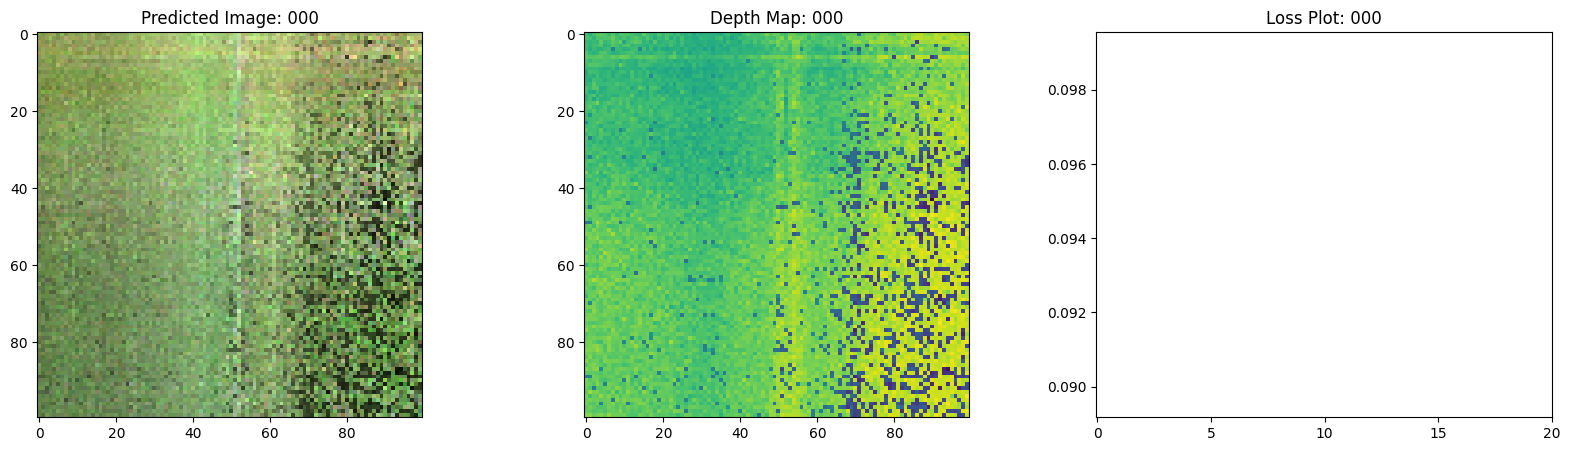

16/16 [==============================] - 8s 274ms/step - loss: 0.0944 - psnr: 10.4377 - val_loss: 0.0661 - val_psnr: 12.0919
Epoch 2/20
1/1 [==============================] - 0s 181ms/steposs: 0.0617 - psnr: 12.60


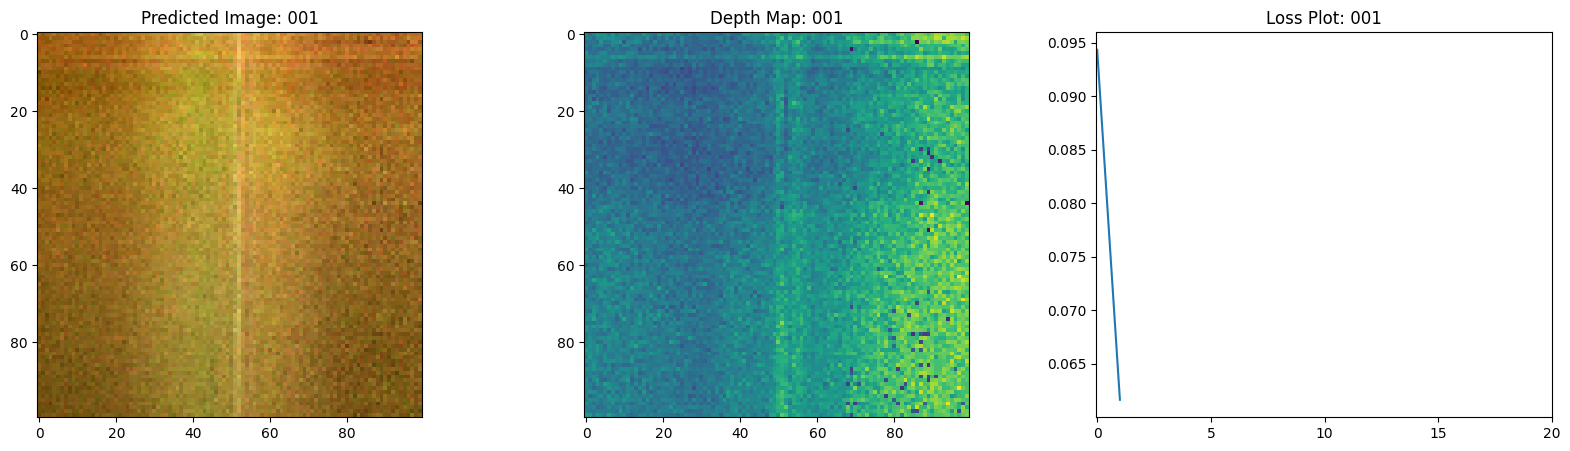

16/16 [==============================] - 5s 267ms/step - loss: 0.0617 - psnr: 12.6084 - val_loss: 0.0649 - val_psnr: 12.2311
Epoch 3/20
1/1 [==============================] - 0s 181ms/steposs: 0.0585 - psnr: 12.74


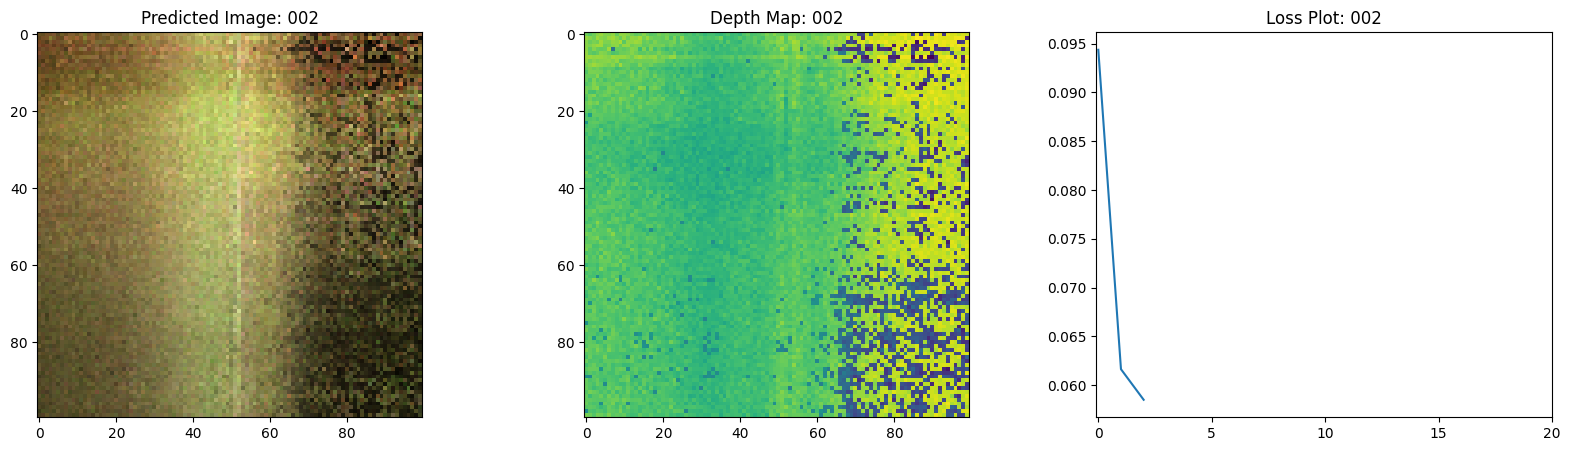

16/16 [==============================] - 5s 277ms/step - loss: 0.0585 - psnr: 12.7427 - val_loss: 0.0637 - val_psnr: 12.2763
Epoch 4/20
1/1 [==============================] - 0s 182ms/steposs: 0.0555 - psnr: 13.00


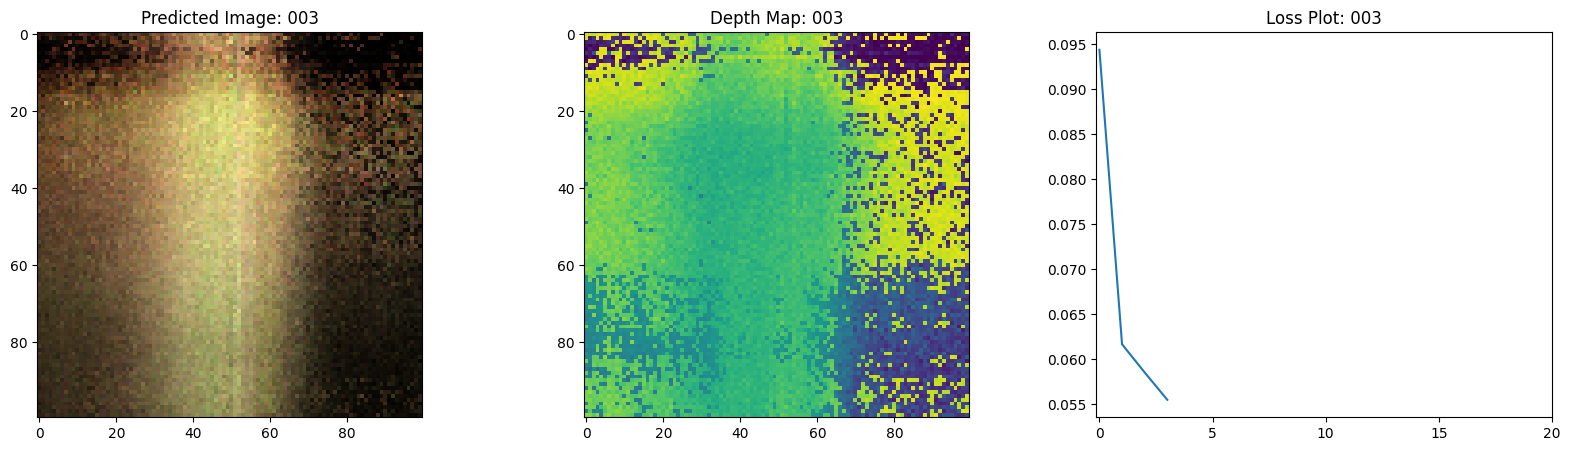

16/16 [==============================] - 5s 272ms/step - loss: 0.0555 - psnr: 13.0065 - val_loss: 0.0572 - val_psnr: 12.8524
Epoch 5/20
1/1 [==============================] - 0s 181ms/steposs: 0.0484 - psnr: 13.58


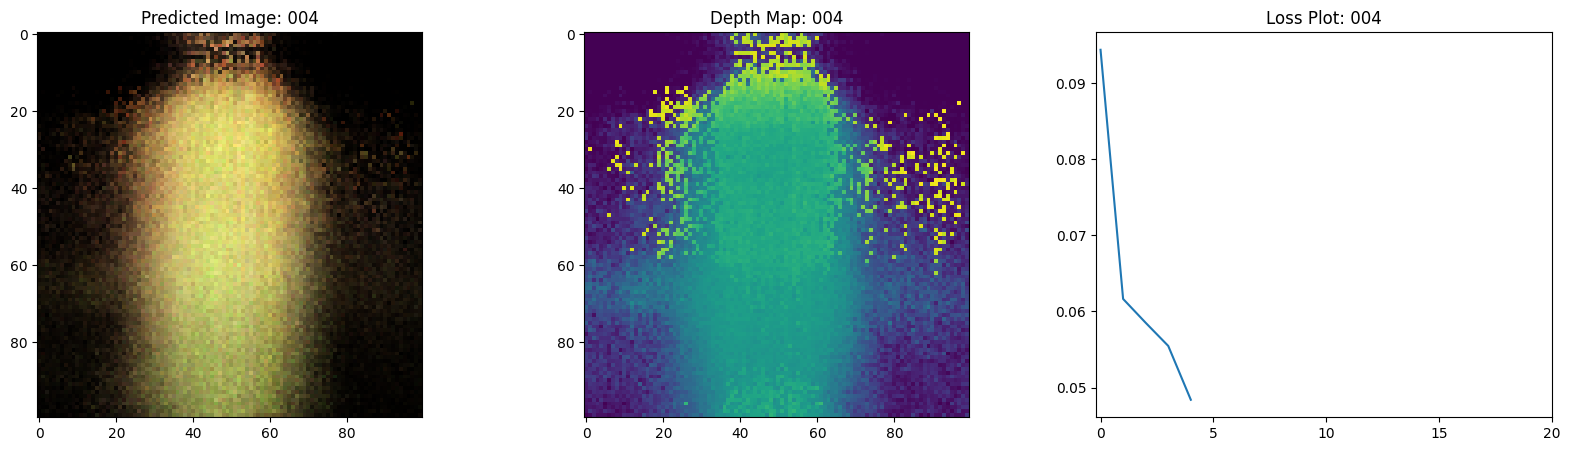

16/16 [==============================] - 6s 286ms/step - loss: 0.0484 - psnr: 13.5864 - val_loss: 0.0446 - val_psnr: 13.8425
Epoch 6/20
1/1 [==============================] - 0s 331ms/steposs: 0.0368 - psnr: 14.70


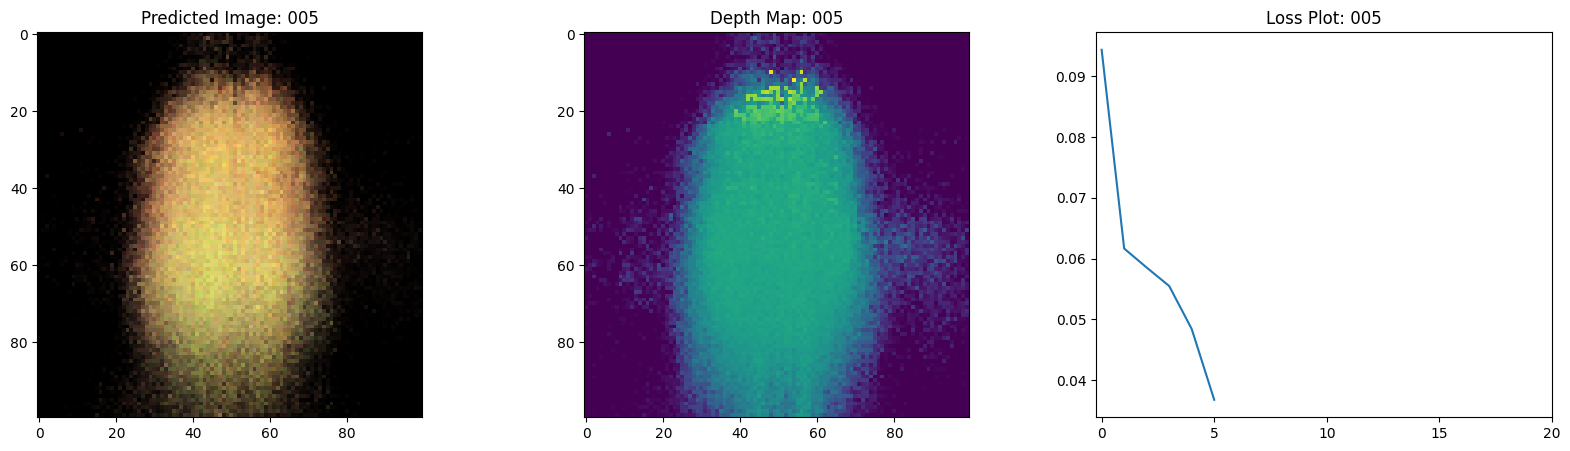

16/16 [==============================] - 6s 280ms/step - loss: 0.0368 - psnr: 14.7058 - val_loss: 0.0343 - val_psnr: 14.8151
Epoch 7/20
1/1 [==============================] - 0s 334ms/steposs: 0.0313 - psnr: 15.29


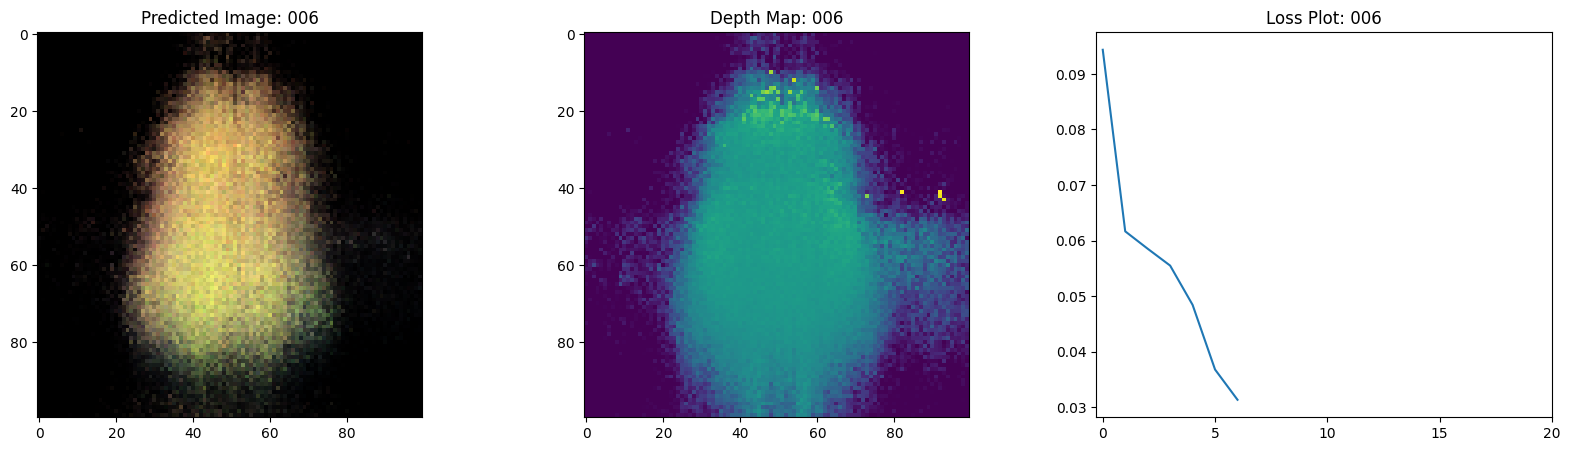

16/16 [==============================] - 6s 283ms/step - loss: 0.0313 - psnr: 15.2920 - val_loss: 0.0308 - val_psnr: 15.2051
Epoch 8/20
1/1 [==============================] - 0s 184ms/steposs: 0.0280 - psnr: 15.77


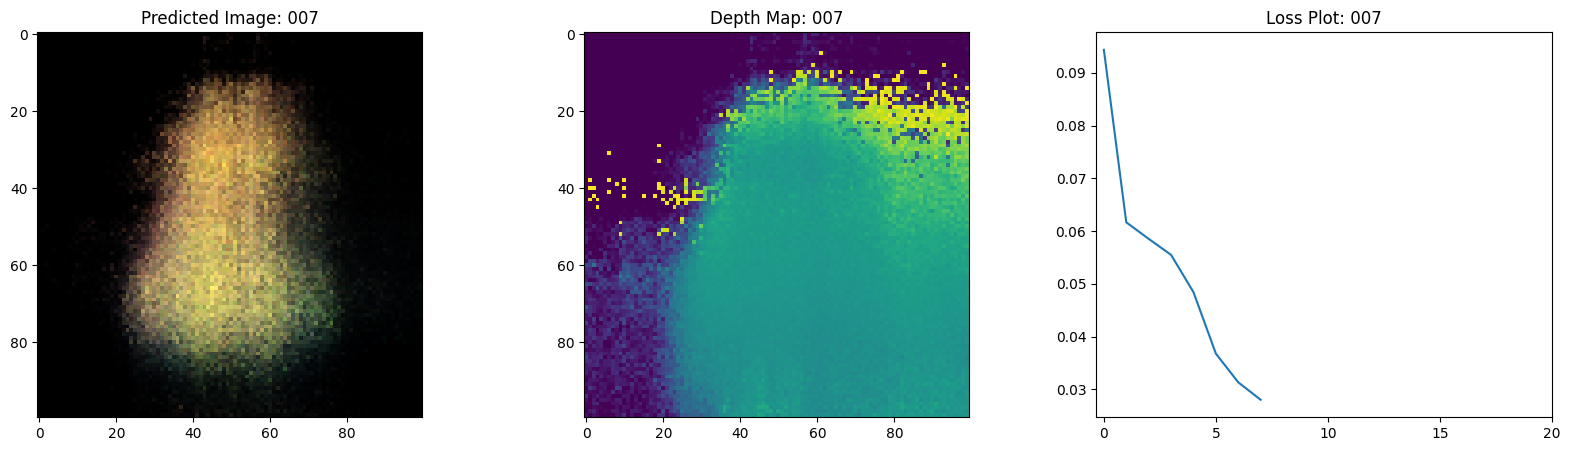

16/16 [==============================] - 5s 253ms/step - loss: 0.0280 - psnr: 15.7789 - val_loss: 0.0287 - val_psnr: 15.6135
Epoch 9/20
1/1 [==============================] - 0s 205ms/steposs: 0.0261 - psnr: 16.04


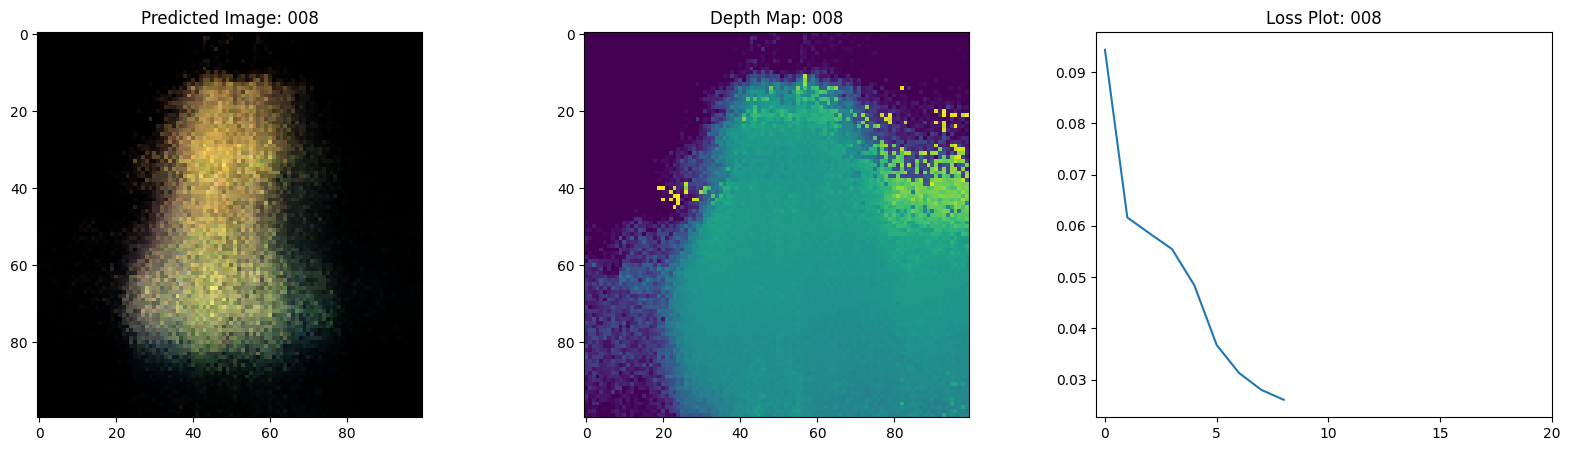

16/16 [==============================] - 6s 296ms/step - loss: 0.0261 - psnr: 16.0461 - val_loss: 0.0260 - val_psnr: 16.0299
Epoch 10/20
1/1 [==============================] - 0s 200ms/steposs: 0.0244 - psnr: 16.33


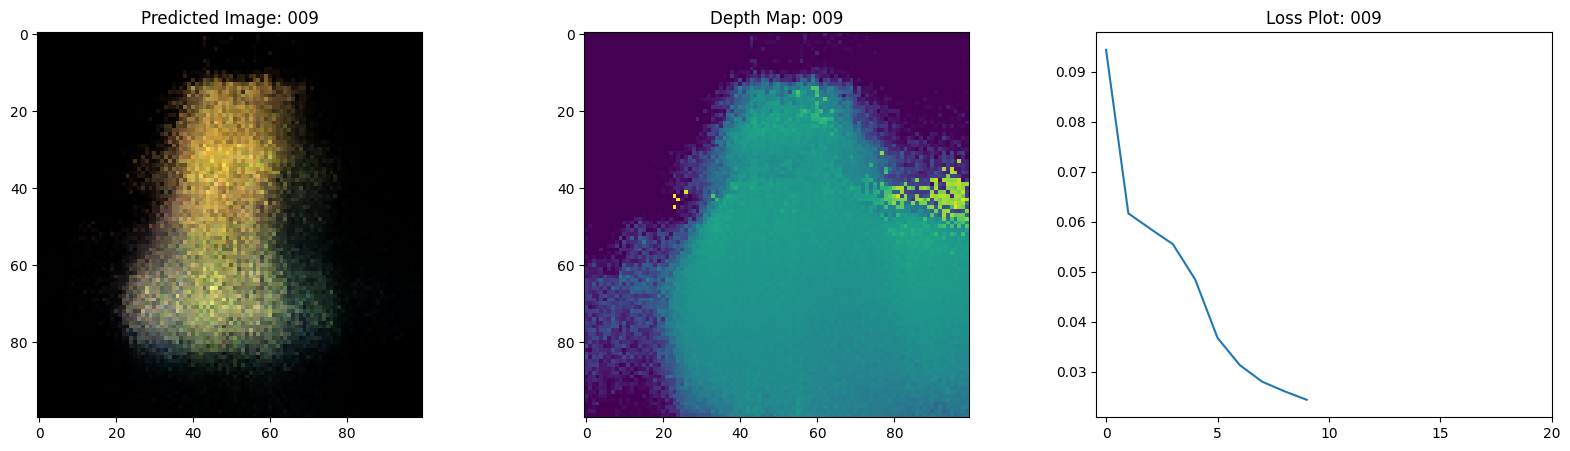

16/16 [==============================] - 6s 270ms/step - loss: 0.0244 - psnr: 16.3320 - val_loss: 0.0244 - val_psnr: 16.3062
Epoch 11/20
1/1 [==============================] - 0s 202ms/steposs: 0.0214 - psnr: 16.88


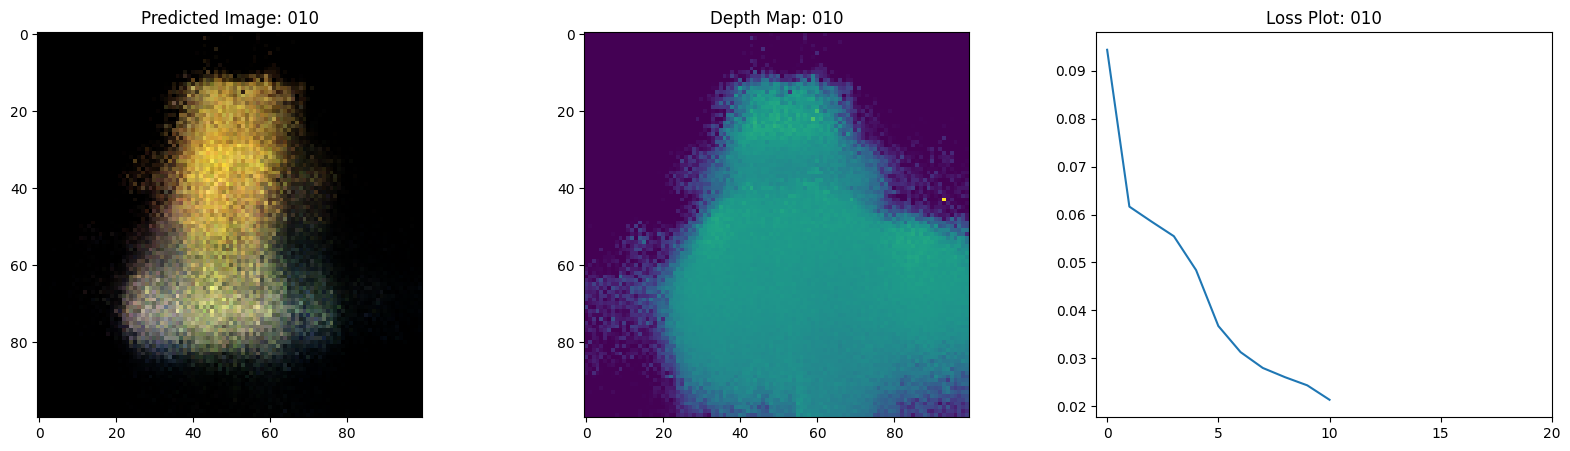

16/16 [==============================] - 6s 259ms/step - loss: 0.0214 - psnr: 16.8862 - val_loss: 0.0207 - val_psnr: 16.9579
Epoch 12/20
1/1 [==============================] - 0s 204ms/steposs: 0.0192 - psnr: 17.32


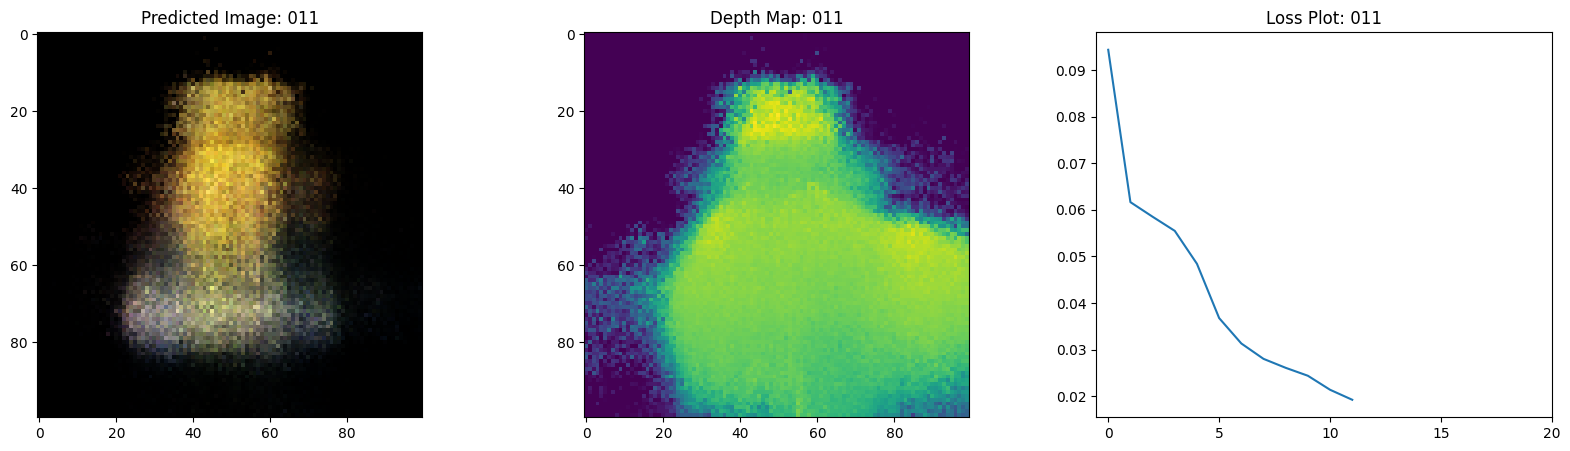

16/16 [==============================] - 5s 261ms/step - loss: 0.0192 - psnr: 17.3272 - val_loss: 0.0188 - val_psnr: 17.3608
Epoch 13/20
1/1 [==============================] - 0s 204ms/steposs: 0.0185 - psnr: 17.51


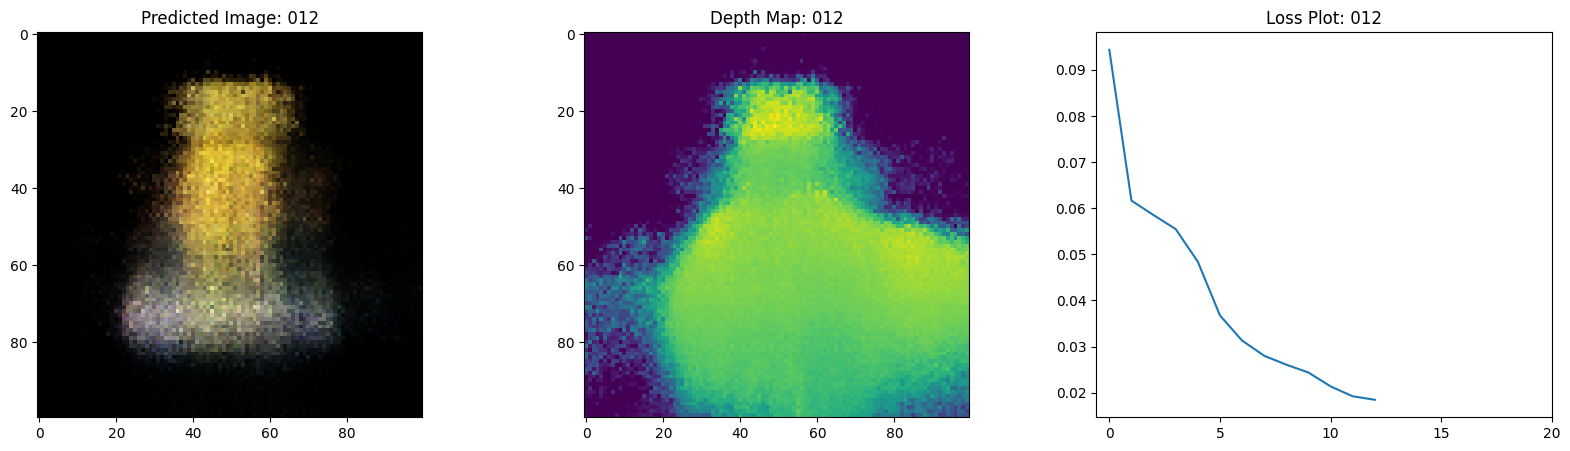

16/16 [==============================] - 5s 259ms/step - loss: 0.0185 - psnr: 17.5100 - val_loss: 0.0173 - val_psnr: 17.7148
Epoch 14/20
1/1 [==============================] - 0s 202ms/steposs: 0.0167 - psnr: 17.92


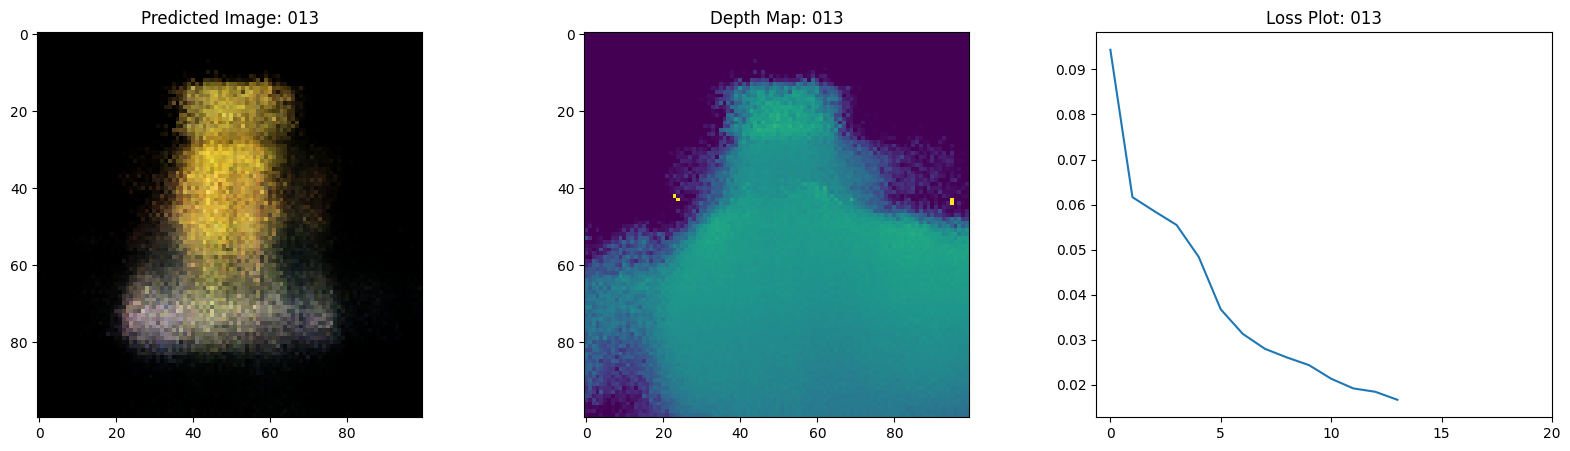

16/16 [==============================] - 6s 280ms/step - loss: 0.0167 - psnr: 17.9235 - val_loss: 0.0164 - val_psnr: 17.9698
Epoch 15/20
1/1 [==============================] - 0s 200ms/steposs: 0.0156 - psnr: 18.21


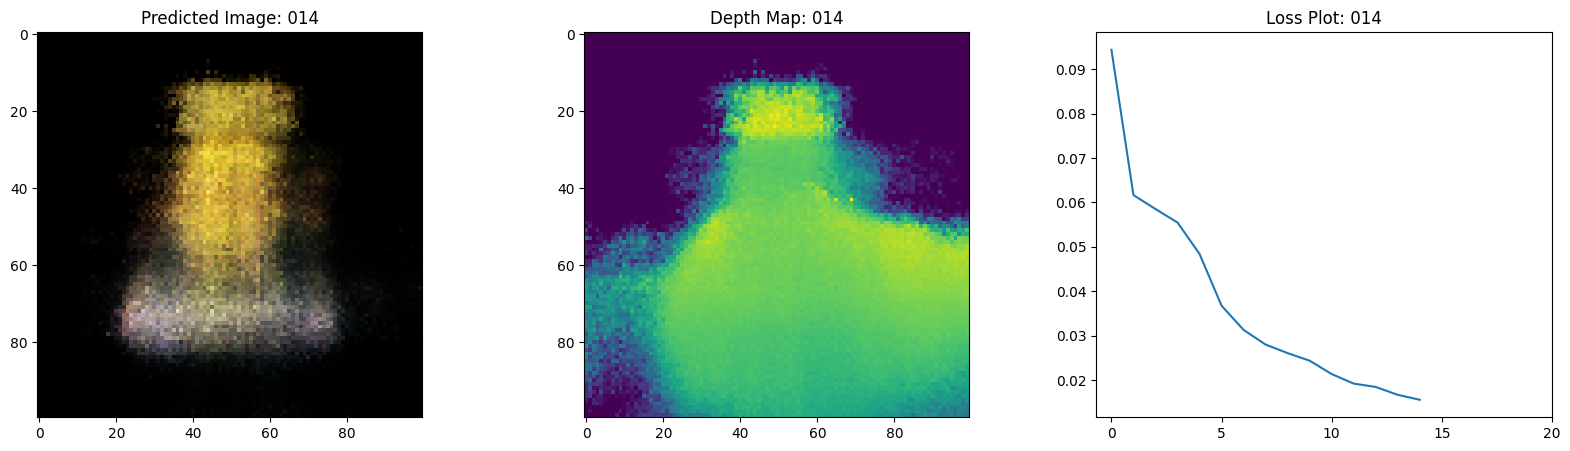

16/16 [==============================] - 5s 255ms/step - loss: 0.0156 - psnr: 18.2157 - val_loss: 0.0154 - val_psnr: 18.1837
Epoch 16/20
1/1 [==============================] - 0s 202ms/steposs: 0.0156 - psnr: 18.19


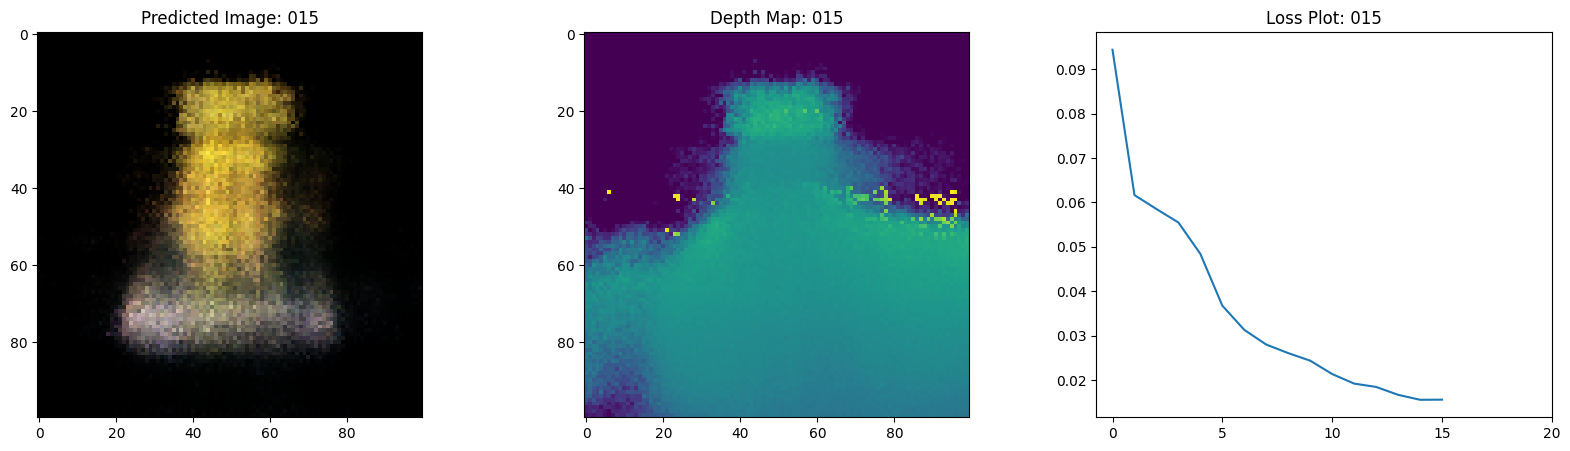

16/16 [==============================] - 5s 263ms/step - loss: 0.0156 - psnr: 18.1937 - val_loss: 0.0146 - val_psnr: 18.4235
Epoch 17/20
1/1 [==============================] - 0s 198ms/steposs: 0.0144 - psnr: 18.54


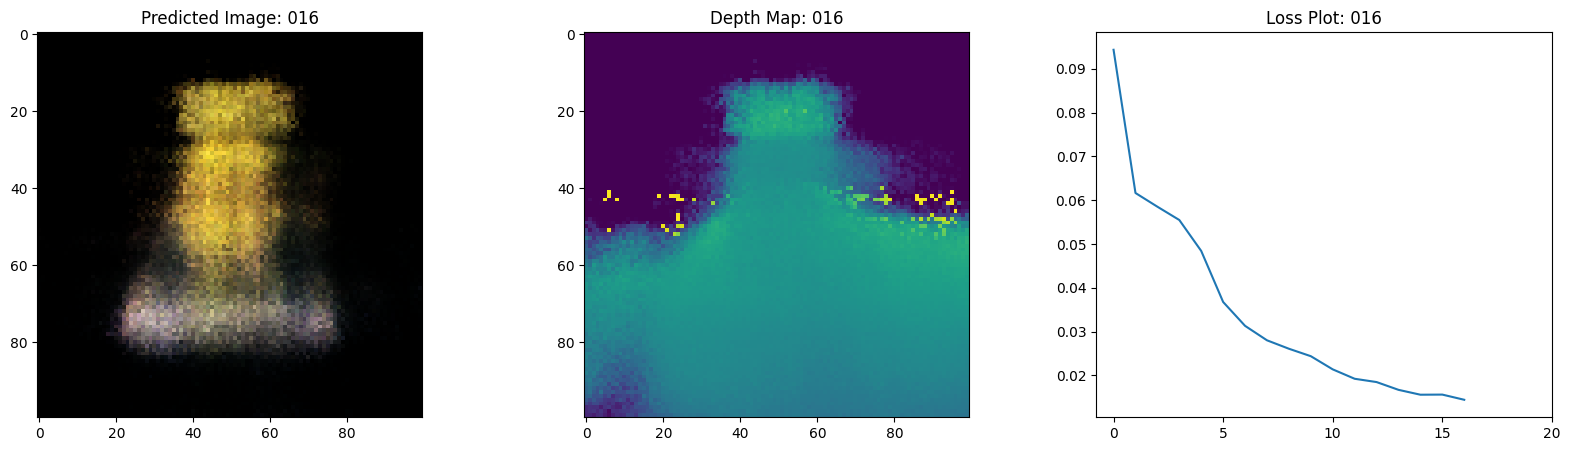

16/16 [==============================] - 5s 262ms/step - loss: 0.0144 - psnr: 18.5494 - val_loss: 0.0143 - val_psnr: 18.5430
Epoch 18/20
1/1 [==============================] - 0s 286ms/steposs: 0.0136 - psnr: 18.77


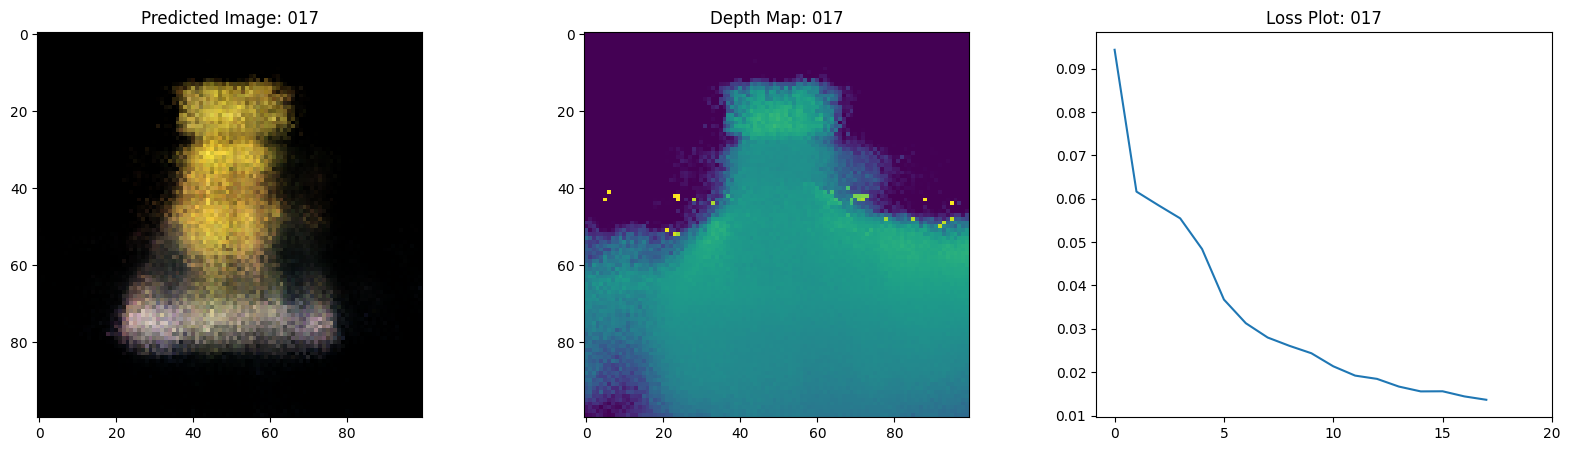

16/16 [==============================] - 6s 265ms/step - loss: 0.0136 - psnr: 18.7795 - val_loss: 0.0141 - val_psnr: 18.5909
Epoch 19/20
1/1 [==============================] - 0s 187ms/steposs: 0.0130 - psnr: 18.98


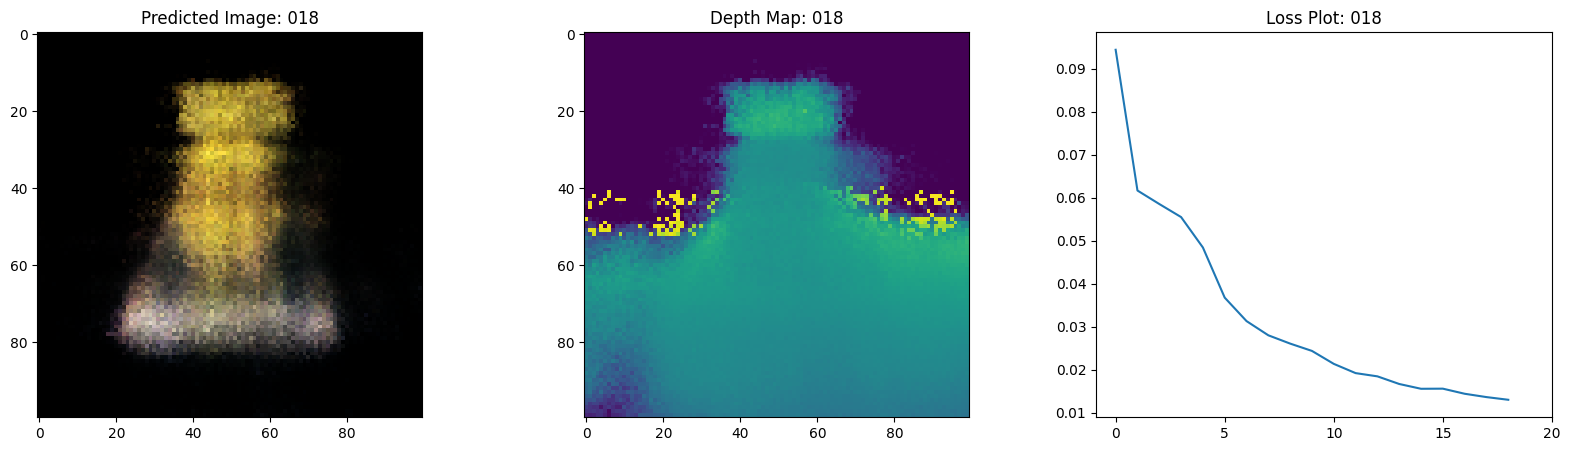

16/16 [==============================] - 6s 267ms/step - loss: 0.0130 - psnr: 18.9823 - val_loss: 0.0130 - val_psnr: 18.9384
Epoch 20/20
1/1 [==============================] - 0s 183ms/steposs: 0.0129 - psnr: 19.00


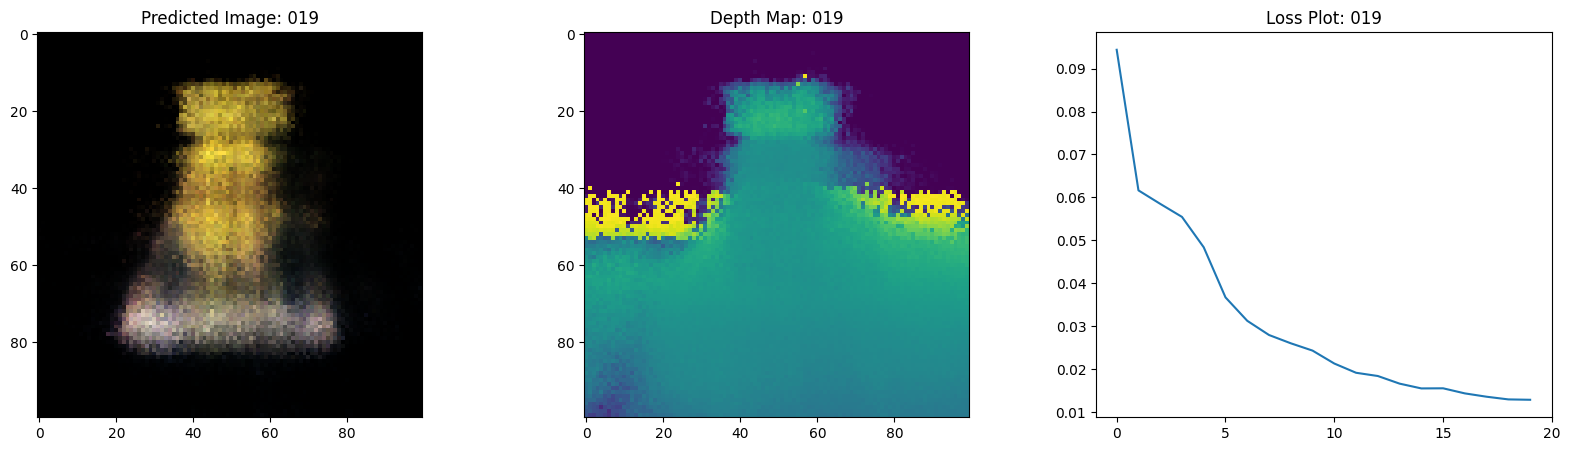

16/16 [==============================] - 6s 259ms/step - loss: 0.0129 - psnr: 19.0063 - val_loss: 0.0128 - val_psnr: 19.0257


100%|██████████| 100/100 [00:01<00:00, 96.88it/s]


In [5]:

class NeRF(keras.Model):
    def __init__(self, nerf_model):
        super().__init__()
        self.nerf_model = nerf_model

    def compile(self, optimizer, loss_fn):
        super().compile()
        self.optimizer = optimizer
        self.loss_fn = loss_fn
        self.loss_tracker = keras.metrics.Mean(name="loss")
        self.psnr_metric = keras.metrics.Mean(name="psnr")

    def train_step(self, inputs):
        # Get the images and the rays.
        (images, rays) = inputs
        (rays_flat, t_vals) = rays

        with tf.GradientTape() as tape:
            # Get the predictions from the model.
            rgb, _ = render_rgb_depth(
                model=self.nerf_model, rays_flat=rays_flat, t_vals=t_vals, rand=True
            )
            loss = self.loss_fn(images, rgb)

        # Get the trainable variables.
        trainable_variables = self.nerf_model.trainable_variables

        # Get the gradeints of the trainiable variables with respect to the loss.
        gradients = tape.gradient(loss, trainable_variables)

        # Apply the grads and optimize the model.
        self.optimizer.apply_gradients(zip(gradients, trainable_variables))

        # Get the PSNR of the reconstructed images and the source images.
        psnr = tf.image.psnr(images, rgb, max_val=1.0)

        # Compute our own metrics
        self.loss_tracker.update_state(loss)
        self.psnr_metric.update_state(psnr)
        return {"loss": self.loss_tracker.result(), "psnr": self.psnr_metric.result()}

    def test_step(self, inputs):
        # Get the images and the rays.
        (images, rays) = inputs
        (rays_flat, t_vals) = rays

        # Get the predictions from the model.
        rgb, _ = render_rgb_depth(
            model=self.nerf_model, rays_flat=rays_flat, t_vals=t_vals, rand=True
        )
        loss = self.loss_fn(images, rgb)

        # Get the PSNR of the reconstructed images and the source images.
        psnr = tf.image.psnr(images, rgb, max_val=1.0)

        # Compute our own metrics
        self.loss_tracker.update_state(loss)
        self.psnr_metric.update_state(psnr)
        return {"loss": self.loss_tracker.result(), "psnr": self.psnr_metric.result()}

    @property
    def metrics(self):
        return [self.loss_tracker, self.psnr_metric]


test_imgs, test_rays = next(iter(train_ds))
test_rays_flat, test_t_vals = test_rays

loss_list = []


class TrainMonitor(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        loss = logs["loss"]
        loss_list.append(loss)
        test_recons_images, depth_maps = render_rgb_depth(
            model=self.model.nerf_model,
            rays_flat=test_rays_flat,
            t_vals=test_t_vals,
            rand=True,
            train=False,
        )

        # Plot the rgb, depth and the loss plot.
        fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(20, 5))
        ax[0].imshow(keras.utils.array_to_img(test_recons_images[0]))
        ax[0].set_title(f"Predicted Image: {epoch:03d}")

        ax[1].imshow(keras.utils.array_to_img(depth_maps[0, ..., None]))
        ax[1].set_title(f"Depth Map: {epoch:03d}")

        ax[2].plot(loss_list)
        ax[2].set_xticks(np.arange(0, EPOCHS + 1, 5.0))
        ax[2].set_title(f"Loss Plot: {epoch:03d}")

        fig.savefig(f"images/{epoch:03d}.png")
        plt.show()
        plt.close()


num_pos = H * W * NUM_SAMPLES
nerf_model = get_nerf_model(num_layers=8, num_pos=num_pos)

model = NeRF(nerf_model)
model.compile(
    optimizer=keras.optimizers.Adam(), loss_fn=keras.losses.MeanSquaredError()
)

# Create a directory to save the images during training.
if not os.path.exists("images"):
    os.makedirs("images")

model.fit(
    train_ds,
    validation_data=val_ds,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    callbacks=[TrainMonitor()],
)


def create_gif(path_to_images, name_gif):
    filenames = glob.glob(path_to_images)
    filenames = sorted(filenames)
    images = []
    for filename in tqdm(filenames):
        images.append(imageio.imread(filename))
    kargs = {"duration": 0.25}
    imageio.mimsave(name_gif, images, "GIF", **kargs)


create_gif("images/*.png", "training.gif")

1/1 [==============================] - 0s 186ms/step


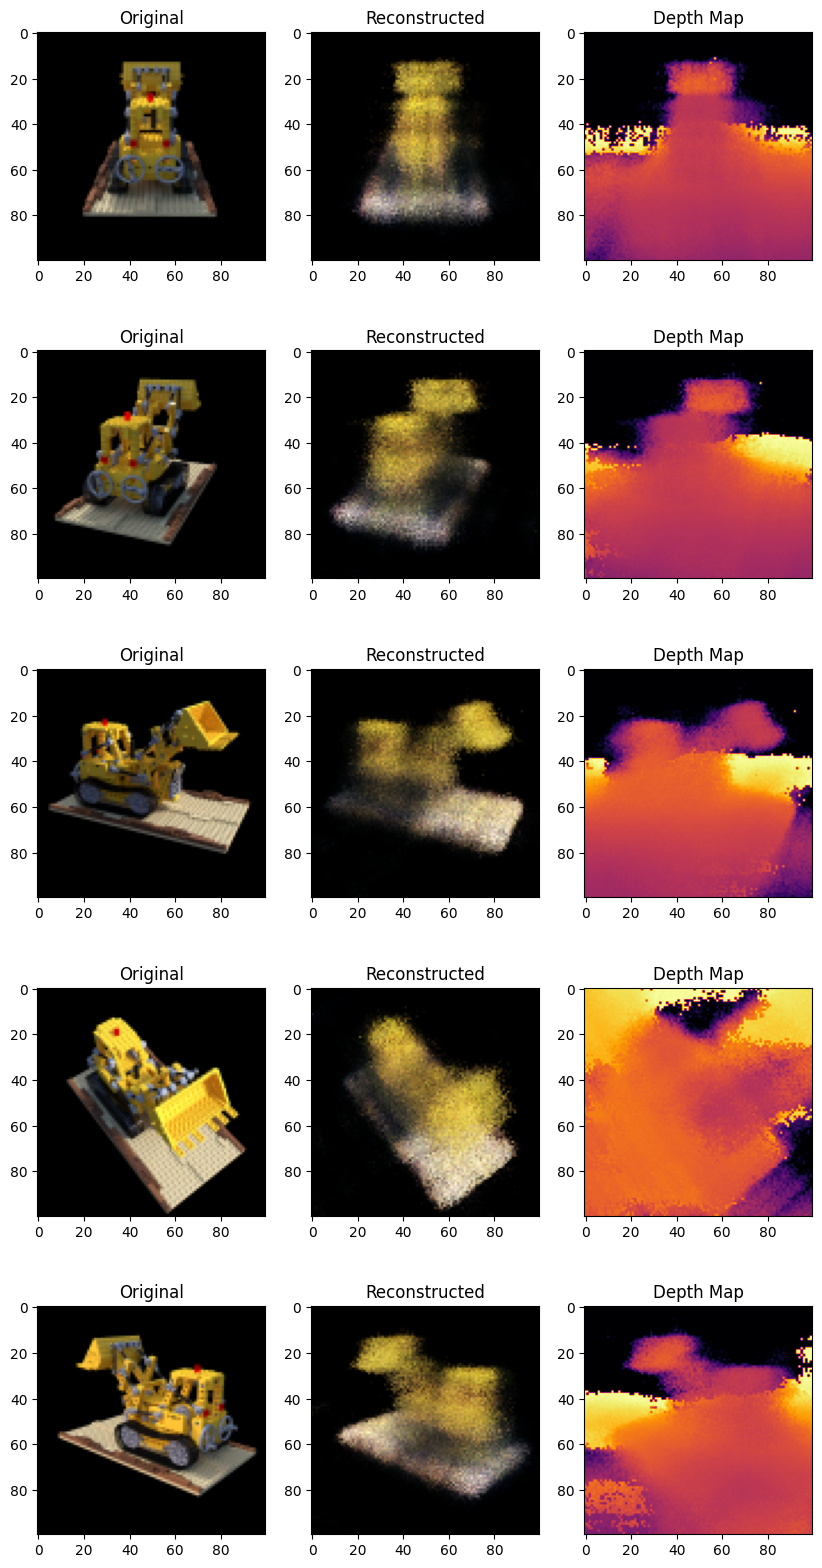

In [6]:
# Get the trained NeRF model and infer.
nerf_model = model.nerf_model
test_recons_images, depth_maps = render_rgb_depth(
    model=nerf_model,
    rays_flat=test_rays_flat,
    t_vals=test_t_vals,
    rand=True,
    train=False,
)

# Create subplots.
fig, axes = plt.subplots(nrows=5, ncols=3, figsize=(10, 20))

for ax, ori_img, recons_img, depth_map in zip(
    axes, test_imgs, test_recons_images, depth_maps
):
    ax[0].imshow(keras.utils.array_to_img(ori_img))
    ax[0].set_title("Original")

    ax[1].imshow(keras.utils.array_to_img(recons_img))
    ax[1].set_title("Reconstructed")

    ax[2].imshow(keras.utils.array_to_img(depth_map[..., None]), cmap="inferno")
    ax[2].set_title("Depth Map")